# Debag window size extraction

System: Linux
Release: 6.8.0-51-generic
Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
Expend window size by 2 *  50
region_length 130
CCATTCAGCGTTTTGGGGTCTGTTTGTTTTTATTGTTATCCCACCCCACACCGCCCCGAGGCGCGCGCGCGCGCGCGCACACACACACACACACACACACACACACATACACACACGCACACTGGTGAAT
130
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 3007 from reads.CG,0.txt into reads.combined_basemods.h5, new size 3007   0% | 00:00<…

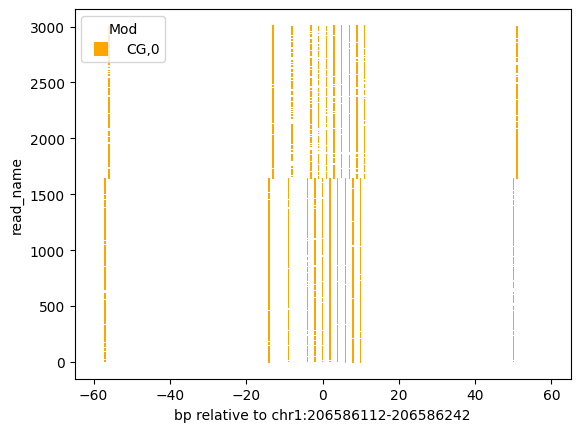

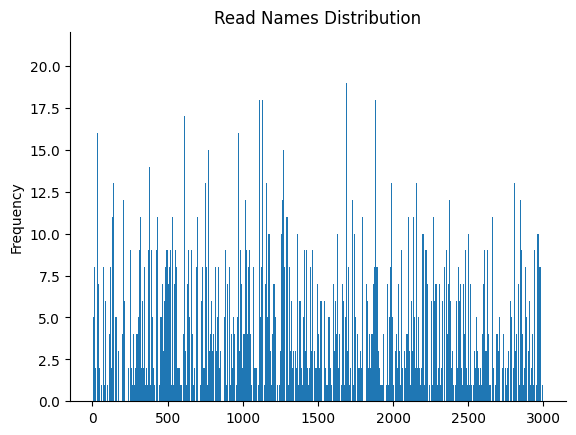

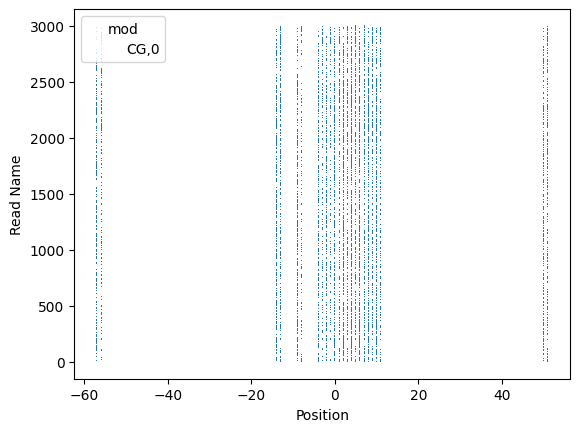

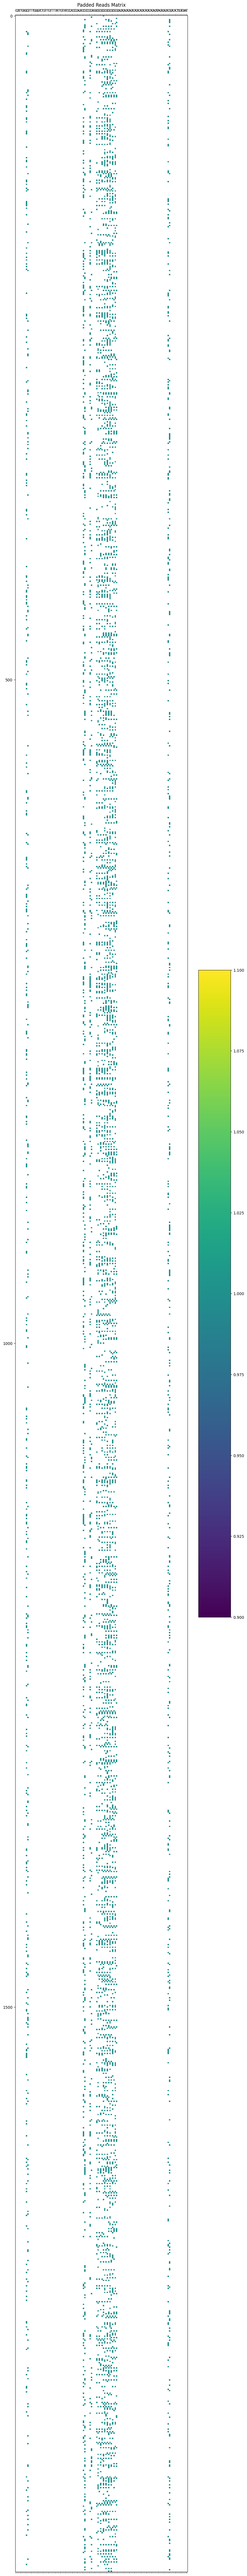

Padded reads saved to padded_reads_unedited_T_primerES_nCATS_mCthresh0.7_t2t_v1_1_chr1:206586112-206586242_2025-02-03.npy


In [23]:
import platform
import sys
import pysam
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dimelo import parse_bam, plot_reads, load_processed

def system_info():
    """Print system information."""
    print('System:', platform.system())
    print('Release:', platform.release())
    print('Version:', platform.version())
    print('Processor:', platform.processor())
    print('Python version:', sys.version)

def get_reference_sequence(ref_genome_file,  region_chr, region_start, region_end):
    """Fetch reference sequence from genome file."""
    try:
        ref_seq = pysam.FastaFile(ref_genome_file).fetch(region_chr, region_start, region_end)
        ref_seq_list = list(ref_seq)
        print(ref_seq)
        print(len(ref_seq))
        return ref_seq_list
    except Exception as e:
        print("Error fetching reference sequence:", e)
        return None

def create_output_directory(path):
    """Create output directory if it doesn't exist."""
    try:
        output_dir = Path(path)
        output_dir.mkdir(exist_ok=True)
        return output_dir
    except Exception as e:
        print("Error creating output directory:", e)
        return None

def extract_from_bam(bam_path, ref_genome_file, output_dir, window_size=None, threshold_mC=0.99, 
                    num_cores=32, regions='chr1:206586162-206586192', motifs=['CG,0'], 
                    output_name='extract_output'):
    """Processes a BAM file using parse_bam.extract and plots the extracted reads."""
    try:
        extract_file, extract_regions = parse_bam.extract(
            input_file=bam_path,
            output_name=output_name,
            ref_genome=ref_genome_file,
            output_directory=output_dir,
            regions=regions,
            motifs=motifs,
            thresh=threshold_mC,
            window_size=window_size,
        )

        plot_reads.plot_reads(
            extract_file,
            regions,
            motifs=motifs,
            window_size=window_size,
            sort_by=['shuffle', 'strand'],
            s=1
        )

        plt.xlabel(f'bp relative to {regions}')
        plt.show()

        return extract_file, extract_regions
    except Exception as e:
        print("Error in BAM extraction:", e)
        return None, None

def process_extracted_reads(extract_file, regions, motifs, ref_seq_list):
    """
    Process extracted reads into a DataFrame.

    Warning: make sure that the ref_seq_list was created using the same region and reference genome using the function: 
        motifs=['CG,0']
        ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)  
    """
    try:
        reads, read_names, mods, regions_dict = load_processed.readwise_binary_modification_arrays(
            file=extract_file,
            regions=regions,
            motifs=motifs
        )
        reads_df = pd.DataFrame({
            'read_name': read_names,
            'mod': mods,
            'pos': reads
        }).explode('pos')

        # reads_df['pos_shifted'] = reads_df['pos'] + 15
        region_length = len(ref_seq_list)
        reads_df['pos_shifted'] = reads_df['pos'] + (region_length // 2)
        return reads_df, regions_dict
    except Exception as e:
        print("Error processing extracted reads:", e)
        return None, None

def visualize_data(reads_df):
    """Generate visualizations for the data."""
    try:
        reads_df['read_name'].plot(kind='hist', bins=1600, title='Read Names Distribution')
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.show()

        sns.scatterplot(
            data=reads_df,
            x="pos",
            y="read_name",
            hue="mod",
            s=0.5,
            marker="s",
            linewidth=0
        )
        plt.xlabel('Position')
        plt.ylabel('Read Name')
        plt.show()
    except Exception as e:
        print("Error in visualization:", e)

def create_padded_reads(reads_df, regions_dict, region_length):
    """Generate padded reads matrix."""
    try:
        read_names_unique = np.unique(reads_df['read_name'])
        num_reads = len(read_names_unique)
        reads_dict = {name: i for i, name in enumerate(read_names_unique)}
        padded_reads = np.full((num_reads, region_length), np.nan)

        for i in range(len(reads_df['read_name'])):
            padded_reads[reads_dict[reads_df['read_name'][i]], reads_df['pos_shifted'][i]] = 1

        return padded_reads
    except Exception as e:
        print("Error creating padded reads matrix:", e)
        return None

def plot_padded_reads(padded_reads, ref_seq_list):
    """Plot padded reads matrix using matshow with x-ticks as reference sequence."""
    try:
        plt.figure(figsize=(10, 150))
        plt.matshow(padded_reads, fignum=1)
        plt.colorbar()
        plt.title("Padded Reads Matrix")
        plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size='small') #, rotation=90)
        # plt.xticks(range(len(seq_list)), seq_list, size='small')
        # plt.xlabel("Reference Sequence")

        plt.show()
    except Exception as e:
        print("Error plotting padded reads matrix:", e)

def save_padded_reads(padded_reads, output_dir, file_name):
    """Save padded reads as a NumPy array."""
    try:
        np.save(Path(output_dir, file_name), padded_reads)
        print(f"Padded reads saved to {file_name}")
    except Exception as e:
        print("Error saving padded reads:", e)


def main():
    """Main function to execute all tasks."""
    system_info()

    experiment_name = "unedited_T_primerES_nCATS"
    threshold_mC =  0.7 #  0.9 #0.99
    bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

    date_today = datetime.today().strftime('%Y-%m-%d')

    ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')
    reg_genome_version = "t2t_v1_1"
    # t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
    region_chr = 'chr1'


    # Expend window size
    expand_window_size = 50 # 50 #000
    expand_window_size
    print("Expend window size by 2 * ", expand_window_size)
    region_start = 206586162 - expand_window_size
    region_end = 206586192 + expand_window_size
    region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
    region_length = region_end - region_start
    print("region_length", region_length)


    save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
    output_dir = create_output_directory("./dimelo_v2_output")

    motifs=['CG,0']
    ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)


    extract_file, extract_regions = extract_from_bam(
        bam_path=bam_path,
        ref_genome_file=ref_genome_v1_1_file,
        output_dir=output_dir,
        regions=region_str,
        motifs=motifs,
        output_name='extracted_reads',
        threshold_mC=threshold_mC,
    )

    if extract_file:
        reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list)
        visualize_data(reads_df)

        padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
        if padded_reads is not None:
            plot_padded_reads(padded_reads, ref_seq_list)
            save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)
    
if __name__ == "__main__":
    main()


10

System: Linux
Release: 6.8.0-51-generic
Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
Expend window size by 2 *  10
region_length 50
CCACCCCACACCGCCCCGAGGCGCGCGCGCGCGCGCGCACACACACACAC
50
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 2925 from reads.CG,0.txt into reads.combined_basemods.h5, new size 2925   0% | 00:00<…

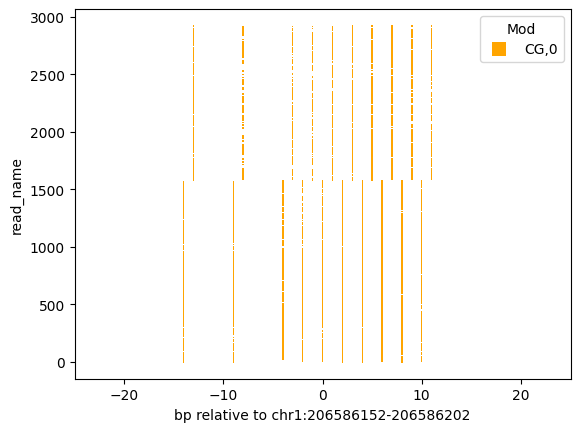

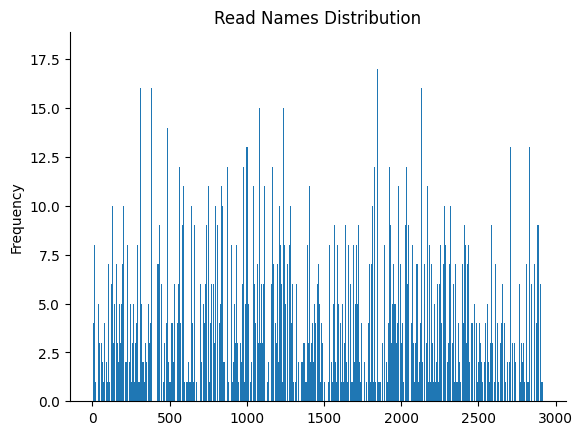

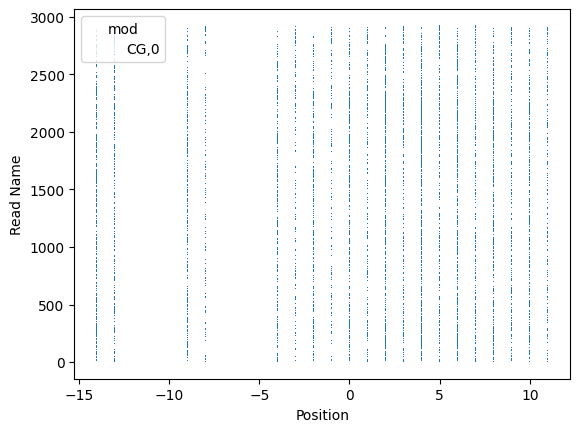

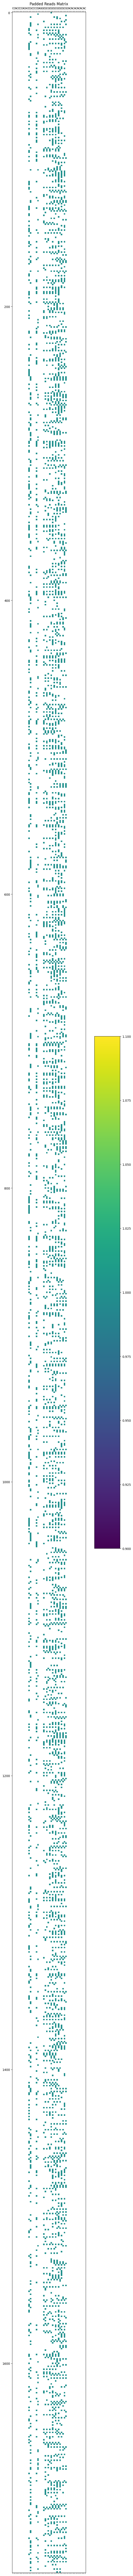

Padded reads saved to padded_reads_unedited_T_primerES_nCATS_mCthresh0.7_t2t_v1_1_chr1:206586152-206586202_2025-02-03.npy


In [19]:
# system_info()

# experiment_name = "unedited_T_primerES_nCATS"
# threshold_mC =  0.7 #  0.9 #0.99
# bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

# date_today = datetime.today().strftime('%Y-%m-%d')

# ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')
# reg_genome_version = "t2t_v1_1"
# # t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
# region_chr = 'chr1'

# print("Expend window size by 2 * ", expand_window_size)
# region_start = 206586162 - expand_window_size
# region_end = 206586192 + expand_window_size
# region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
# region_length = region_end - region_start
# print("region_length", region_length)


# save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
# output_dir = create_output_directory("./dimelo_v2_output")

# motifs=['CG,0']
# ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)


# extract_file, extract_regions = extract_from_bam(
#     bam_path=bam_path,
#     ref_genome_file=ref_genome_v1_1_file,
#     output_dir=output_dir,
#     regions=region_str,
#     motifs=motifs,
#     output_name='extracted_reads',
#     threshold_mC=threshold_mC,
# )

# if extract_file:
#     reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list)
#     visualize_data(reads_df)

#     padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
#     if padded_reads is not None:
#         plot_padded_reads(padded_reads, ref_seq_list)
#         save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)
 